# Predict Salary Notebook

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from module import constants
from module.tuner import tune_catboost_cv
from module.data import (
    normalize_salary_to_million_idr_monthly,
    read_raw, clean_data, clean_company, clean_city, clean_role
)

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import make_scorer, mean_squared_error as mse
from sklearn.model_selection import KFold, cross_validate


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
DATA_PATH = 'datasets/data.html'

raw_data = read_raw(DATA_PATH)
raw_data.head()

,role,company,years_of_exp,city,country,gender,currency,salary,mode,period,compensation,verified
0,tester,Purchase to unlock 👆,3,Bandung,ID,Male,IDR,30000000,Net,Monthly,RSU so stonks.,Verified
1,HES Engineer,Purchase to unlock 👆,12,Pekanbaru,ID,Male,IDR,54000000,Gross,Monthly,*Vacation allowance = 1 month salary *Full med...,NaN
2,Lead Front End,Purchase to unlock 👆,5,Jakarta,ID,Male,IDR,16500000,Gross,Monthly,NaN,NaN
3,Android Developer,Purchase to unlock 👆,5,Jakarta,ID,Male,IDR,23500000,Gross,Monthly,"Insurance, work from home.",NaN
4,dats scientist,Purchase to unlock 👆,6,jakarta,ID,Male,IDR,14600000,Net,Monthly,NaN,NaN


# Cleaning

In [24]:
df = clean_data(raw_data)
print('Data shape:', df.shape)

df.head(1)

Data shape: (500, 12)


,role,company,years_of_exp,city,country,gender,currency,salary,mode,period,compensation,verified
0,tester,other,3,bandung,ID,male,IDR,30.0,Net,Monthly,rsu so stonks.,Verified


# Exploration

## Num of Unique Values

In [25]:
categorical_cols = ['role', 'company', 'years_of_exp', 'city', 'country', 'gender']
nunique_values = df[categorical_cols].nunique()
print(nunique_values)
print('Total:', nunique_values.sum())

role            289
company           6
years_of_exp     17
city             60
country           5
gender            3
dtype: int64
Total: 380


## Categorical Feature Distribution

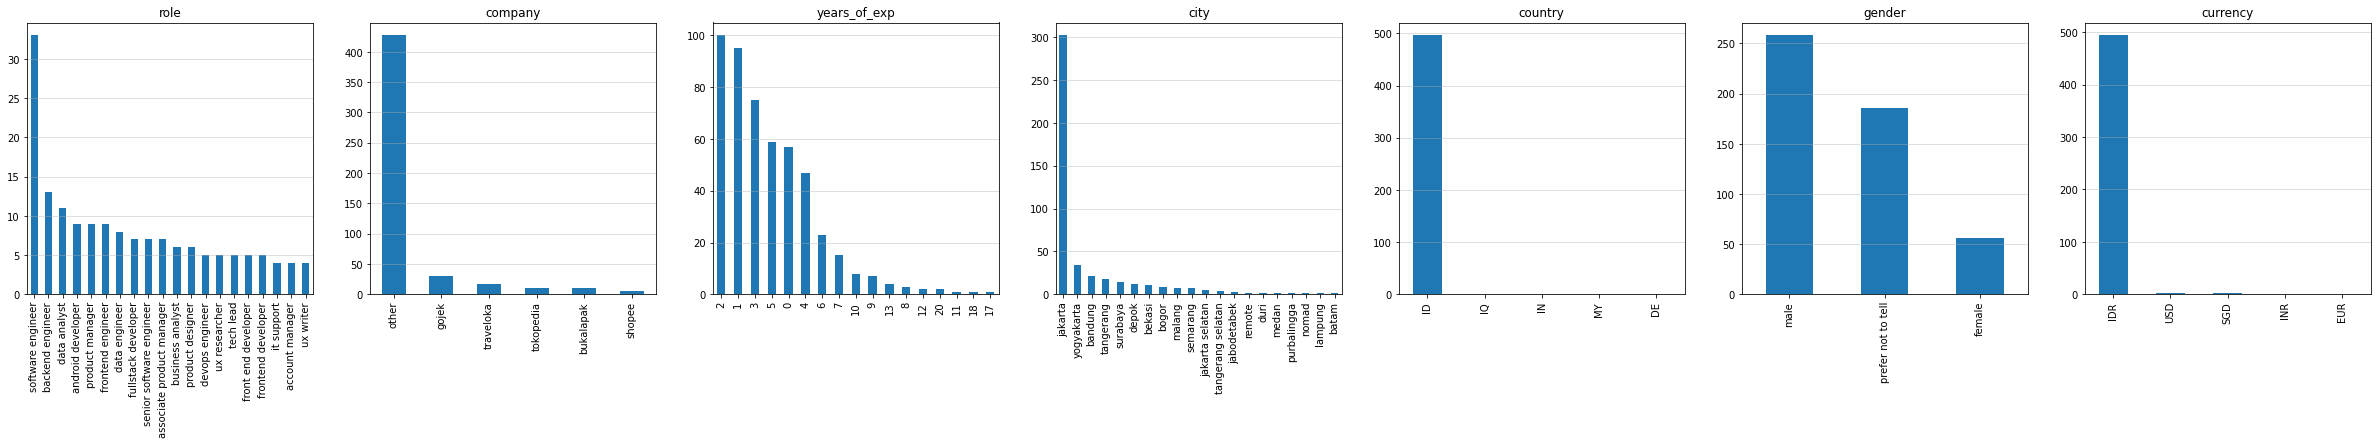

In [27]:
top = 20
cols = ['role', 'company', 'years_of_exp', 'city', 'country', 'gender', 'currency']
fig, ax = plt.subplots(1, len(cols), figsize=(len(cols) * 6, 5))

for i, col in enumerate(cols):
    temp_data = df[col].value_counts()[:top]
    temp_data.plot(kind='bar', ax=ax[i])
    ax[i].set_title(col)
    ax[i].grid(axis='y', alpha=0.5)

plt.show()

## Salary Distribution

C:\Users\rerlan01\Desktop\temp_rimba\predict_salary\env\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


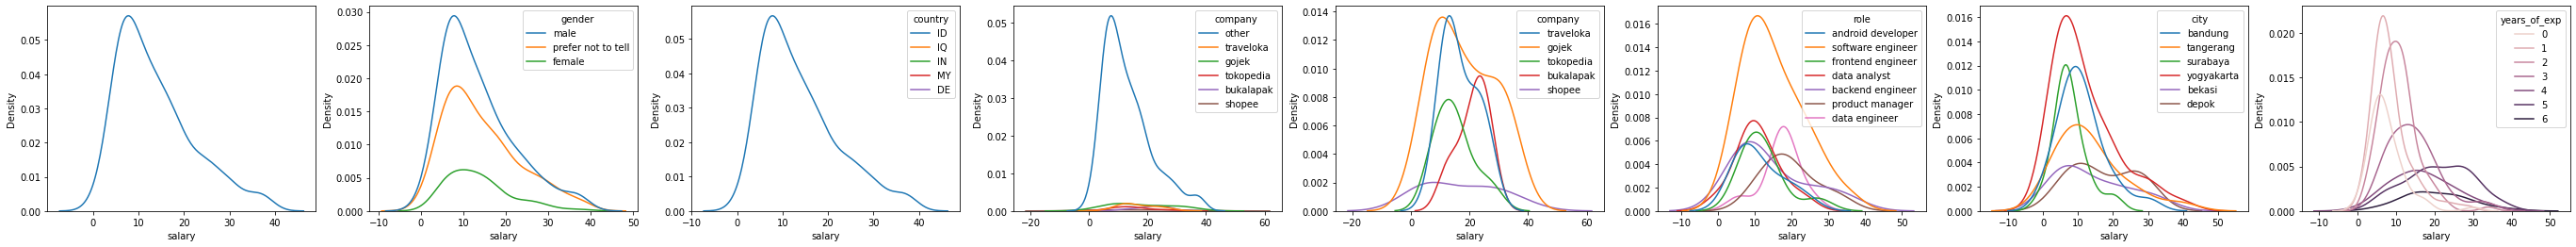

In [28]:
n_rows = 8
top = 7
fig, ax = plt.subplots(1, n_rows, figsize=(6 * n_rows, 4))

def kdeplot(data, ax, x='salary', hue=None):
    sns.kdeplot(x=x, data=data, ax=ax, hue=hue)

kdeplot(ax=ax[0], data=df)
kdeplot(ax=ax[1], data=df, hue='gender')
kdeplot(ax=ax[2], data=df, hue='country')
kdeplot(ax=ax[3], data=df, hue='company')
kdeplot(ax=ax[4], hue='company', data=df[df.company != 'other'])
kdeplot(ax=ax[5], hue='role', data=df[df.role.isin(df.role.value_counts().index[:top])])
kdeplot(ax=ax[6], hue='city', data=df[df.city.isin(df.city.value_counts().index[1:top])])
kdeplot(ax=ax[7], hue='years_of_exp',
        data=df[df.years_of_exp.isin(df.years_of_exp.value_counts().index[:top])])

plt.show()

## Salary vs Years of Exp

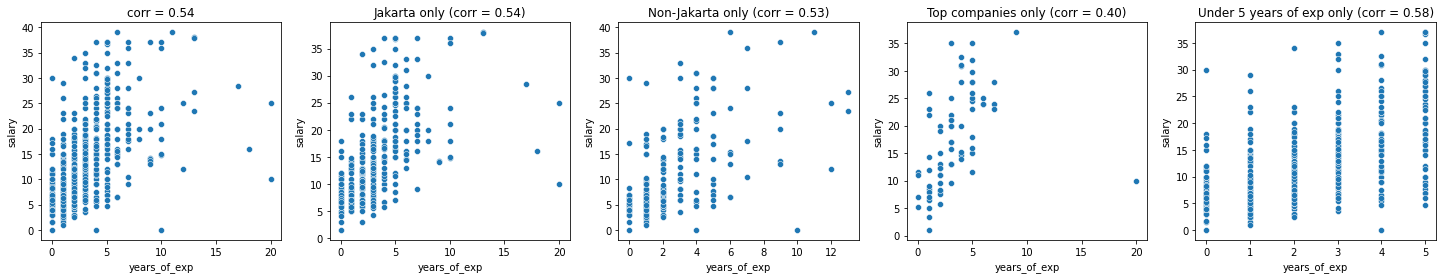

In [29]:
n_rows = 5
fig, ax = plt.subplots(1, n_rows, figsize=(5 * n_rows, 4))

def plot_scatter(data, ax, x='years_of_exp', y='salary', title=None):
    sns.scatterplot(x=x, y=y, data=data, ax=ax)
    
    corr = data[[x, y]].corr().loc[x, y]
    corr = f'corr = {corr:.2f}'
    title = title + f' ({corr})' if title != None else corr
    ax.set_title(title)

plot_scatter(ax=ax[0], data=df)
plot_scatter(ax=ax[1], data=df[df.city == 'jakarta'], title='Jakarta only')
plot_scatter(ax=ax[2], data=df[df.city != 'jakarta'], title='Non-Jakarta only')
plot_scatter(ax=ax[3], data=df[df.company != 'other'], title='Top companies only')
plot_scatter(ax=ax[4], data=df[df.years_of_exp <= 5], title='Under 5 years of exp only')

# Modeling

## Baseline: CatBoost

In [33]:
# config

seed = 0
early_stopping_rounds = 200
n_splits = 5
n_trials = 5
timeout = 30
verbose = 0
direction = 'maximize'

In [34]:
rmse = lambda y_true, y_pred: np.sqrt(mse(y_true, y_pred))
scoring = make_scorer(rmse, greater_is_better=False)

cv = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
fit_params = dict(early_stopping_rounds=early_stopping_rounds, verbose=verbose)
cv_params = dict(cv=cv, fit_params=fit_params, scoring=scoring)

In [ ]:
print('\nBaseline model')
df = clean_data(raw_data)

feature_cols = ['role', 'company', 'years_of_exp', 'city', 'country', 'gender']
cat_features = [0, 1, 3, 4, 5]
X, y = df[feature_cols], df.salary
print('Data shape:', X.shape)

clf_params = dict(cat_features=cat_features, random_seed=seed)
best_params, study = tune_catboost_cv(
    X, y, seed=seed, n_trials=n_trials, timeout=timeout,
    cv_params=cv_params, clf_params=clf_params, direction=direction
)

## Feature Engineering

In [11]:
df.head()

,role,company,years_of_exp,city,country,gender,currency,salary,mode,period,compensation,verified
0,tester,other,3,bandung,ID,male,IDR,30.00,Net,Monthly,rsu so stonks.,Verified
1,lead front end,other,5,jakarta,ID,male,IDR,16.50,Gross,Monthly,NaN,NaN
2,android developer,other,5,jakarta,ID,male,IDR,23.50,Gross,Monthly,"insurance, work from home.",NaN
3,dats scientist,other,6,jakarta,ID,male,IDR,14.60,Net,Monthly,NaN,NaN
4,software engineer,other,2,tangerang,ID,male,IDR,13.75,Net,Monthly,private insurance,NaN


### Drop `country`

In [12]:
print('\nWithout `country`')
df = clean_data(raw_data)

feature_cols = ['role', 'company', 'years_of_exp', 'city', 'gender']
cat_features = [0, 1, 3, 4]
X, y = df[feature_cols], df.salary
print('Data shape:', X.shape)

clf_params = dict(cat_features=cat_features, random_seed=seed)
best_params, study = tune_catboost_cv(
    X, y, seed=seed, n_trials=n_trials, timeout=timeout,
    cv_params=cv_params, clf_params=clf_params, direction=direction
)


Without `country`
Data shape: (500, 5)

Best Score: -6.401225556292047
> Finished in: 599.86s
> Number of completed trials: 50
> Best Params: 
{
    "learning_rate": 0.024299378421070134,
    "l2_leaf_reg": 0.01027862822059732,
    "colsample_bylevel": 0.08857531944624657,
    "depth": 9,
    "boosting_type": "Plain",
    "bootstrap_type": "Bernoulli",
    "min_data_in_leaf": 7,
    "one_hot_max_size": 5,
    "subsample": 0.8147859416546583
}

> Done cross-validating in: 14.08s
Refitted CV score: -6.401225556292047


### Clean `city` and Drop `gender`

In [13]:
print('\nClean `city` and drop `gender`')
df = clean_data(raw_data)
df.city = df.apply(clean_city, axis=1)

feature_cols = ['role', 'company', 'years_of_exp', 'city']
cat_features = [0, 1, 3]
X, y = df[feature_cols], df.salary
print('Data shape:', X.shape)

clf_params = dict(cat_features=cat_features, random_seed=seed)
best_params, study = tune_catboost_cv(
    X, y, seed=seed, n_trials=n_trials, timeout=timeout,
    cv_params=cv_params, clf_params=clf_params, direction=direction
)


Clean `city` and drop `gender`
Data shape: (500, 4)

Best Score: -6.39271545712032
> Finished in: 559.57s
> Number of completed trials: 50
> Best Params: 
{
    "learning_rate": 0.027519089881354823,
    "l2_leaf_reg": 0.13552574978980222,
    "colsample_bylevel": 0.0882341400745347,
    "depth": 10,
    "boosting_type": "Ordered",
    "bootstrap_type": "MVS",
    "min_data_in_leaf": 8,
    "one_hot_max_size": 6
}

> Done cross-validating in: 17.15s
Refitted CV score: -6.39271545712032


### Bag of Words: `role`

In [14]:
print('\nBag of words: `role`')
df = clean_data(raw_data)
df.city = df.apply(clean_city, axis=1)
df.role = df.apply(clean_role, axis=1)

# extract token count
vec = CountVectorizer(binary=True)
vec.fit(df.role)
role_binary = pd.DataFrame(
    vec.transform(df.role).toarray(),
    columns=vec.get_feature_names_out()
)

# prepare data
cols = ['company', 'years_of_exp', 'city']
X, y = pd.concat([role_binary, df[cols]], axis=1), df.salary
cat_features = np.where(X.columns != 'years_of_exp')[0]
print('Data shape:', X.shape)

clf_params = dict(cat_features=cat_features, random_seed=seed)
best_params, study = tune_catboost_cv(
    X, y, seed=seed, n_trials=n_trials, timeout=timeout,
    cv_params=cv_params, clf_params=clf_params, direction=direction
)


Bag of words: `role`
Data shape: (500, 214)

Best Score: -6.097253843520895
> Finished in: 606.27s
> Number of completed trials: 26
> Best Params: 
{
    "learning_rate": 0.015723166049376257,
    "l2_leaf_reg": 0.0186790567412678,
    "colsample_bylevel": 0.05306340740650805,
    "depth": 4,
    "boosting_type": "Plain",
    "bootstrap_type": "Bernoulli",
    "min_data_in_leaf": 13,
    "one_hot_max_size": 3,
    "subsample": 0.7354519800195846
}

> Done cross-validating in: 16.02s
Refitted CV score: -6.097253843520895


### Current Best Model

In [151]:
df = clean_data(raw_data)
df.city = df.apply(clean_city, axis=1)
df.role = df.apply(clean_role, axis=1)

# extract token count
vec = CountVectorizer(binary=True)
vec.fit(df.role)
role_binary = pd.DataFrame(
    vec.transform(df.role).toarray(),
    columns=vec.get_feature_names_out()
)

# prepare data
cols = ['company', 'years_of_exp', 'city']
X, y = pd.concat([role_binary, df[cols]], axis=1), df.salary
cat_features = np.where(X.columns != 'years_of_exp')[0]
print('Data shape:', X.shape)

params = {
    "learning_rate": 0.01757716447501079,
    "l2_leaf_reg": 0.026970399937897144,
    "colsample_bylevel": 0.0470613563139236,
    "depth": 8,
    "boosting_type": "Plain",
    "bootstrap_type": "Bayesian",
    "min_data_in_leaf": 5,
    "one_hot_max_size": 6,
    "bagging_temperature": 9.394010600072782
}

clf_params = dict(cat_features=cat_features, random_seed=seed)
model = CatBoostRegressor(**{**params, **clf_params})
cv_results = cross_validate(model, X, y, **cv_params)
cv_results

Data shape: (500, 214)


{'fit_time': array([3.21473265, 3.29417205, 3.20338297, 3.38679433, 3.3887496 ]),
 'score_time': array([0.        , 0.        , 0.        , 0.        , 0.01573849]),
 'test_score': array([-6.26976073, -6.19132827, -5.96580204, -5.92111684, -5.19201688])}

In [152]:
cv_results['test_score'].mean()

-5.908004951440844

### Save Model

In [153]:
clf_params = dict(cat_features=cat_features, random_seed=seed)
model = CatBoostRegressor(**{**params, **clf_params})

model.fit(X, y, **fit_params)

In [154]:
sample = ['data scientist', 'tokopedia', 1, 'jakarta']
count = vec.transform([sample[0]]).toarray().tolist()[0]
sample = count + sample[1:]
model.predict([sample])

array([12.6096941])

In [156]:
import pickle

with open('./model/count_vectorizer.pkl', 'wb') as file:
    pickle.dump(vec, file)
    
with open('./model/catboost_model.pkl', 'wb') as file:
    pickle.dump(model, file)